<a href="https://colab.research.google.com/github/ev1025/1day1commit/blob/main/%EC%BD%94%EB%93%9C%EC%8A%A4%ED%85%8C%EC%9D%B4%EC%B8%A0/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%B4%9D%EC%A0%95%EB%A6%AC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 하이퍼파라미터   
!pip3 install hyperopt



### Exhaustive Gride Search
- 범위로 설정한 모든 값으로 탐색진행
- 하이퍼파라미터 값 3 x 3 x n(cv값) 회 진행
- 튜닝할 하이퍼 파라미터의 수가 많을때는 사용하기 효율적이지 않다.


In [ ]:
params = {
    "xgbclassifier__max_depth" : [2,4,6]                 # "모델__하이퍼파라미터" : 탐색할 값 목록
    "xgblcassifier__colsample_bytree" : [0.2, 0.4, 0.8],
}

In [ ]:
from sklearn.mdoel_selection import GriedSearchCV

gird = GridSearchCV(모델,
                    param_grid = params,  # 미리 지정해둔 파라미터 범위리스트
                    scoring = 'roc_auc',  # 사용할 점수
                    cv = n,               # 검증할 횟수
                    verbose = n           # 검증결과 얼마나 상세하게 볼지(0~3, 3이 제일 상세하게)
)
grid.fit(X_train, y_train)

grid.best_params_    # 최적의 하이퍼파라미터
grid.best_score_     # 최적의 검증 점수
gird.cv_results_      # 검증 결과 목록

### Randomized Search
- 범위로 설정한 값에서 무작위로 추출(횟수는  n_iter x cv의 수만큼만 진행)
- 범위가 넓고 빠르지만 모든 조합에 대해 검증하지 않아 가장 이상적인 조합을 발견하지 못할 수 있다.
- scipy.stats로 범위를 분포로 지정도 가능


In [ ]:
from scipy.stats.distributions import uniform
from sklearn.impute import SimpleImputer

params = {
    "simpleimpouter__strategy" : ['median', 'mean']                 # 인코딩, 결측치처리도 가능 
    "xgbclassifier__colsample_bytree" : uniform(loc=0.5, scale=0.5) # 0.5 ~ 1 사이에서 랜덤추출
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

randomized = RandomizedSearchCV(
    모델,
    param_distributioon=params,  # 조정할 하이퍼파라미터
    scoring='roc_auc',         
    n_iter = n,                  # 돌릴 횟수
    cv = n,                      # 검증할 횟수
    verbose=n,
    random_state=n,
)
randomized.fit(X_train, y_train)

randomized.best_params_   # 최적의 하이퍼파라미터(찾은 값)
randomized.best_score_    # 최적의 검증점수

randomized.cv_results_    # 하이퍼파라미터 탐색 리스트

### Bayesian Search
- 검증할 하이퍼파라미터 범위내에서, 이전에 탐색한 조합중 성능이 좋은 조합을 중심으로 확률적으로 탐색
- hyperopt 라이브러리로 베지안 서치를 할 수 있다.(단, hyperopt에서 제공하는 범위를 사용해야함)
- hyperopt의 fmin는 최종적으로 loss를 가장 작게 만드는 파라미터 조합을 선택(함수를 만들어서 loss와 STATUS값을 제공해야함)
- loss이므로 클수록 좋은 함수는 - 부호를 붙여주어야함
- fmin의 max_evals 수 만큼 하이퍼파라미터 탐색

In [ ]:
# hyperopt 범위 옵션
hp.choice('하이퍼파라미터', list or tuple) # 리스트나 튜플의 값을 선택하여 탐색
hp.randint('하이퍼파라미터', upper)        #  0 ~ upper 사이의 정수를 랜덤으로 선택
hp.uniform('하이퍼파라미터',low, high )    # low ~ high 범위 내의 실수를 랜덤으로 선택
hp.quniform('하이퍼파라미터', low, high, q)# low ~ high 사이 균등분포에서 q간격의 지점에서 랜덤수 선택
hp.normal('하이퍼파라미터', mu, sigma)     # mu(평균), sigma(표준편차)를 갖는 정규분포 모델에서 실수를 랜덤선택

In [ ]:
# Bayesian Search순서 : 1. 튜닝할 params작성 / 2.파이프라인구축 함수 / 3. 학습 및 검증 함수 / 4. fmin으로 loss값 받아서 베이지안서치 
from hyperopt import hp

params= {
    "simpleimputer__strategy" : hp.choice('strategy', ['mean', 'median']), # 목록에서 랜덤선택
    "xgbclassifier__max_depth" : hp.quniform("max_depth", 2, 10, 2)        # 2~10 사이에서 2 간격으로 랜덤선택
    "xgblcassifier__colsample_bytree" : hp.uniform("colsample_bytree", 0.5, 1.0) # 0.5~1.0 사이에서 실수 랜덤선택
}

In [ ]:
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.model.selection import corss_val_score
from sklearn.pipeline import make_pipeline
import numpy as np

def get_pipe(params): # 파이프라인 구축 함수
    params['xgbclassifier__max_depth'] = int(params['xgbclassifier_max_depth']) # 정수형 파라미터로 변경

    pipe = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(),
        XGBClassifier(
            random_state = 2,
            objective = 'binary:logistic',
            eval_metric = 'error',
            n_estimators = 20,
            learning_rate = 0.2,

        ),
    )
    pipe = pipe.set_params(**params) # parmas의 값을 넣어줌
    return pipe


def fit_and_eval(params):      # 학습 및 검증 함수
    pipe = get_pipe(params)    # 모델 생성
    score = cross_val_score(   # 점수 검증
        pipe,
        X_train,
        y_train,
        cv = n,
        scoring='roc_auc',
    )
    avg_cv_score = -np.mean(score) # loss값을 구해야 하므로 높을수록 좋은 값은 -를 붙여줌
    return {"loss": avg_cv_score, "status" : STATUS_OK}  # fmin에 loss와 STATUS 제공

trials = (Trials()) # fmin의 trials에 넣어 실행하면 fit의 학습결과를 모두 저장(grid, randomize의 .cv_results_)

best_params = fmin(    # hyperopt의 fmin은 loss정보를 얻어서 최적의 하이퍼파라미터 탐색
    fn = fit_and_eval, # 학습, 검증 함수
    trials = trials,   # 결과를 저장할 객체
    space = params,    # 하이퍼파라미터 범위
    algo = tpe.suggest,# suggest 알고리즘 사용
    max_evals = n      # 탐색 횟수    
)

In [ ]:
trials.trials # trials에 하이퍼파라미터 탐색 결과 

In [ ]:
trials.best_trial['misc']['vals']    # 최적의 하이퍼파라미터 구성(tiral 목록의 misc의 vals에 저장되어 있음)
-trials.best_trial['result']['loss'] # 최적의 하이퍼파라미터의 검증점수(앞에서 - 붙였으니 다시 -붙여줌)

## 특성선택


### 1. 직관기반 선택
- 데이터가 충분할 때는 예측에 중요하지 않은 특성이 학습데이터에 포함되어 있어도 모델성능에 크게 관여하지 않음(데이터가 적으면 노이즈 과적합이 발생)
- 개발자가 주요하지 않은 특성을 선제적으로 배제(추천 알고리즘에서 사용자ID, 이름 등 제거)

### 2. 특성중요도기반 선택
- 각 특성의 중요도에 따라 특성을 선택
- 회귀모델 : model.coef_
- 분류모델 : model.feature_importances_

### 3. 통계량 기반 특성 선택
- 피어슨 상관계수 : 선형성 타겟의 상관관계를 추측(np.corrcoef)
- 스피어만 상관계수 : 단조성 타겟의 상관계수를 추측(spearmanr)
- SeletKBest : 회귀 or 분류 통계량에 따른 분류
   - 분류타겟 옵션 : f_classif / mutual_info_classif / chi2
   - 회귀타겟 옵션 : f_regression / mutual_info_regression


In [ ]:
from scipy.stats import spearmanr

np.corrcoef(x,y)[0, 1] # 특성 x,y의 선형성 점수
spearmanr(x,y)         # 특성 x,y의 단조성 점수

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif 

selector = SelectKBest(score_func = f_classif, k=n)          # 분류문제, 상위 n개의 특성만 사용
X_train_selected = selector.fit_transform(X_train, y_train)  # 선택된 n개의 특성으로 훈련데이터 생성
X_val_selected = seleector.transform(X_val)                  # 사용할 모델에 model.fit(X_val_selected, y_val)

In [ ]:
X_train.columns[selector.get_support()].tolist()             # SelectKBest에서 선택된 특성 출력

## 특성중요도

#### 1. Mean decrease impurity(MDI)
- 트리기반 모델에서는 각 분기에서 노드의 불순도를 감소시킨다.
- feature_importances_를 통해 특성중요도를 계산할 수 있다.
- High cardinality 특성에 높은 값을 부여하는 문제가 있어서 이런 특성이 있는 경우 해석에 주의해야함

In [ ]:
importance = pd.Series(model.feature_importances_, X_train.columns) # X_train의 인덱스를 갖는특성중요도 시리즈

importance.plot.barh  # 특성중요도 표 생성

#### 2. Drop-Column Importance
- 특성을 하나씩 지워서 모든 특성을 사용했을 때와 특성중요도가 어떻게 달라지는지 확인해보는 방법
- 가장 이상적이나, 시간이 오래걸려서 비효율적이다.

#### 3. Permutation Importance(순열중요도)
- 기존 모델에서 각 특성에 노이즈를 주어서(하나의 특성을 랜덤으로 섞어서 의미없게 만듬) 성능이 어떻게 달라지는지 확인한다.
- 모델을 재학습하지 않아서 빠르고 High Cardinality한 특성에 강하다.
- 특성의 순서만 바꿀 뿐 분포는 변화시키지 않음
- 상관관계가 있는 특성이 존재하면 잘못된 값이 나옴(키2m, 몸무게 30kg)
- 상관관계가 있는 특성이 존재하면 하나의 값에 노이즈를 주어도 다른 특성에서 정보를 얻을 수 있기 때문에 성능이 크게 하락하지 않을 수 있다.(결국, 중요한 특성임에도 중요도가 낮게 나올 수 있다)
- 상관관계가 높은 특성이 존재하는경우 미리 전처리작업을 해주어야한다.

In [ ]:
!pip3 install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,                 # 반드시 fit으로 학습시킨 모델이어야함(모델학습 안시키고 넣으면 오류남)
    scoring='accuracy',
    n_iter= n,             # 10번 반복
    random_state = 2,
)

X_test_ohe = 인코딩.transform(X_test)
permuter.fit(X_test_ohe, y_test) # 전처리된 X_test_ohe로 진행

In [ ]:
feature_names = X_test.columns.tolist()
pi = pd.Seriese(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh() # 특성중요도 그래프

In [ ]:
eli5.show_weights(                  # PI표 생성
    permuter,                       # 모델
    top = None,                     # None = 모두표시 / 숫자 = 표시할 개수
    feature_names = feature_names,  # list로 넣어야함
)

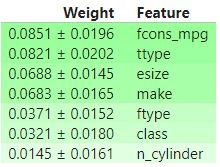

In [ ]:
importance = pd.Series(permuter.feature_importances_, X_test.columns) # 평균보다 높은 특성만 추출
im_mean = importance.mean()                   # 평균 구해서
pi_idx = importance[importance>im_mean].index # 평균보다 높은 특성의 인덱스

rf.fit(X_train[pi_idx],y_train)               # 모델에 특성 적용해서 다시 학습

## ICE PLOT / PDP PLOT

### 1. Individual Conditional Expectation(ICE plot)
- 특성이 증가/감소할 때 모델의 예측값이 어떻게 변하고 영향을 주는지 파악할 수 있다.

In [ ]:
# 알고자하는 특성의 최대~최소범위(range의 마지막숫자가 포함되도록 뒤에 1을 더해주어 범위 설정)
column_test_range = range(X_train_enc[column].min(), X_train_enc[column].max()+1)

results = []

for i in column_test_range:    # column의 값이 최소 ~ 최대일 때
    X_train_enc['column'] = i  
    X_train_proba = model.predict_proba(X_train_enc)[:,1] # 각 값에서 확률의 예측
    results.append(X_train_proba)

results = np.array(results) # 계산을 위해 변환
results -= results[0]       # 초기값에서의 변화량(각 값에서 [0]값을 빼줌)

In [ ]:
plt.plot(column_test_range, results) # x축 = 특성의 값범위 / y축 = 값이 변화에 따른 타겟값의 변화량

### 2. Partial Dependence Plot(PDP plot)
- 특성의 변화에 따른 타겟값의 변화를 평균으로 나타낸 그래프
- 각 특성이 독립성을 가진다는 전제(상관관계가 높을경우 17세에 대학원을 졸업하는 이상한 값이 출력된다)
- 특성간 상관관계가 높을 경우 미리 전처리 해주어야한다.
- 데이터 분포가 존재하지 않는 부분은 학습이 되지않아 이상한 값을 출력(해석시 주의)

In [ ]:
!pip3 install pdpbox

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot # pdpbox 하나의 특성에 대한 pdp시각화

target_feature = ""           # 특성 선택

isolated= pdp_isolate(              # pdp모델
    model = rf,                     # 모델
    dataset = x_test,               # x데이터
    model_features= x_test.columns, # 특성 목록
    feature = target_feature,       # 분석할 특성
    grid_type = "percentile",       # 격차의 점 간격 설정(equal 개수만큼 동일하게 구분)
    num_grid_points = 10,           # 점의 갯수(type에 따라 달라짐 equal이면 균등격차로 점찍힘)
    # cust_grid_points=[-2, 1, 2, 3, 4, 5, 6, 7],  # 특성값을 찍어 볼 지점을 직접 지정
)

pdp_plot(
    isolated,                      # pdp plot (평균그래프 + 신뢰구간)
    feature_name = target_feature  # 그래프 위에축 이름
) 

In [ ]:
pdp_plot(                 
    isolated,                      # isolate 함수(pdp함수)
    feature_name = target_feature, # 그래프 위,아래 표시할 feature name
    plot_lines = True,    # 개별라인 표시 여부(노란색)
    frac_to_plot = 50,    # 표시할 ice plot 수
    plot_pts_dist=True    # rug plot(데이터의 밑에 수량바) 데이터 분포 표시
)

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot # 2- feature pdp

target_features = ['JobInvolvement','TotalWorkingYears']

ineraction =pdp_interact(     # 2개의 특성 pdp
    model = rf,
    dataset = x_test,    
    model_features = x_test.columns,
    features = target_features,    
)

In [ ]:
pdp_interact_plot(
    ineraction,           # 2특성 그래프
    plot_type=  'gird',# 그래프 방식('contour'도 있음)
    feature_names = target_features
)

- OrdinalEncoder 사용시, x축에 인코딩 된 숫자 대신 원래 값 넣어주려면

In [ ]:
mappings = rf[0].mapping  # 인코딩 된 모든 값들 보기 (rf[0]가 오디널인코딩)
print(mappings)

In [ ]:
mapping_data = list(filter(lambda x: x["col"] == 'Gender', mappings)) # 인코딩 목록화
print(mapping_data) 
 # [{'col':'Gender', 'mapping': Male 1 Female 2 NaN -2}] # 젠더컬럼의 Male은 1 , Female은 2, 결측치는-2로 인코딩

In [ ]:
maps = mapping_data[0]["mapping"] # mapping 부분만 추출
print(type(maps))

In [ ]:
original_value = maps.index.tolist()  # 인코딩 전 범주값  ['Male', 'Female', 'nan']
encoding_value = maps.values.tolist() # 인코딩 후 숫자값  [1, 2, -2]

In [ ]:
pdp_dist = pdp_isolate(
    rf,
    x_test,
    model_features=x_test.columns,
    feature = 'Gender',
    cust_grid_points = [-2, 1, 2],          # x값 지정
)
pdp_plot(pdp_dist, 'Gender')
plt.xticks(encoding_value, original_value)  # x축에 특성 표시

## n233, n234 해야됨